In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
import imhandle as imh
#from extract_data import *
from dual_IDG import DualImageDataGenerator

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
#from keras.metrics import fmeasure
from keras_logger import CSVLogger, ComprehensiveLogger

In [4]:
K.set_image_dim_ordering('th')

In [5]:
def mean_IOU_cpu_for_binary(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    intersection, union = np.logical_and(X, Y).sum(axis=(1, 2, 3)), np.logical_or(X, Y).sum(axis=(1, 2, 3))
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = np.where(union == 0, 1, union)
    return np.mean(intersection / union.astype(np.float64))


def mean_IOU_cpu(X, Y):
    X_fl = X > 0.5
    Y_fl = Y > 0.5
    
    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))

In [6]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.greater(X_fl, 0.5)
    Y_fl = K.greater(Y_fl, 0.5)
    
    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_for_flattened(x, y):
    x = K.clip(x, K.epsilon(), 1.)
    y = K.clip(y, K.epsilon(), 1.)
    x = K.greater(x, 0.5)
    y = K.greater(y, 0.5)
    
    intersection = K.sum(x * y, axis=1)
    union = K.sum(K.maximum(x, y), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [7]:
def bce_gpu(y_true, y_pred):
    # Credits: https://www.kaggle.com/c/ultrasound-nerve-segmentation/forums/t/22951/would-like-to-see-how-others-approached-this-problem-doesn-t-have-to-be/131719
    
    # Workaround for shape bug.
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    
    bce = K.mean(K.binary_crossentropy(y_true_f, y_pred_f), axis=-1)
    return K.mean(bce)

In [8]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def f_score(y_true, y_pred):
    # This function returns f-score (harmonic mean between precision and recall).
    # It is based on Keras function, but first casts inputs to float type.
    
    return fmeasure(K.cast(y_true, 'float32'), K.cast(y_pred, 'float32'))

In [9]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [10]:
#h5f = h5py.File("../data/hdf5_datasets/all_data.hdf5", "r")
h5f = h5py.File("../data/hdf5_datasets/DRISHTI_GS.hdf5", "r")

In [11]:
#h5f.close()

### U-Net architecture

<img src="../reports/pics/u-net-architecture.png" width=60%>

In [12]:
def get_unet(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [45]:
def get_unet_light_and_heavy(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [205]:
model = get_unet_light_and_heavy(img_rows=256, img_cols=256)
model.compile(#optimizer=Adam(lr=1e-6), 
              optimizer=SGD(lr=3e-4, momentum=0.98),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_14 (InputLayer)            (None, 3, 256, 256)   0                                            
____________________________________________________________________________________________________
convolution2d_296 (Convolution2D)(None, 32, 256, 256)  896         input_14[0][0]                   
____________________________________________________________________________________________________
dropout_166 (Dropout)            (None, 32, 256, 256)  0           convolution2d_296[0][0]          
____________________________________________________________________________________________________
convolution2d_297 (Convolution2D)(None, 32, 256, 256)  9248        dropout_166[0][0]                
___________________________________________________________________________________________

#### Training on DRISHTI-GS

In [147]:
# Loading full images of desired resolution:
X = h5f['DRISHTI-GS/256 px/images']
Y = h5f['DRISHTI-GS/256 px/cup']

In [148]:
X, Y

(<HDF5 dataset "images": shape (50, 256, 256, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 256, 256, 1), type "|u1">)

In [150]:
n_folds = 5
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(X.shape[0], n_folds):
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

In [151]:
len(X), len(train_idx_cv[0]), len(test_idx_cv[0])

(50, 40, 10)

In [152]:
#train_idx = h5f['DRISHTI-GS/train_idx']
#test_idx = h5f['DRISHTI-GS/test_idx']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

#### Generator for training and data augmentation

In [76]:
X_train = np.array([X[i] for i in train_idx])
X_train = tf_to_th_encoding(X_train)
#mean_test_img = np.mean([X[i] for i in test_idx], axis=0) / 255.0    # should not be used probably
mean_color = np.mean(X_train, axis=(0, 2, 3), keepdims=True)
std_color = np.std(X_train, axis=(0, 2, 3), keepdims=True)

del X_train

In [153]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                   zoom_range=(0.5, 1.0),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()
#augm_idg = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,
#                              horizontal_flip=True, vertical_flip=True,
#                              rotation_range=0.1, width_shift_range=0.1, height_shift_range=0.1,
#                              zoom_range=(1.0, 2.0),
#                              fill_mode='constant', cval=0.0)
# if using featurewise_center, featurewise_std_normalization or zca_whitening,
# augm_idg.fit(X_train, Y_train) is needed first

In [196]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    # the following line thresholds segmentation mask for DRISHTI-GS, since it contains averaged soft maps:
    batch_y = batch_y >= 128
    # if line above is uncommented, division by 255.0 is not needed
    #batch_y = batch_y / 255.0
    
    #batch_X -= mean_color
    #batch_X /= std_color
    #batch_X = (batch_X - np.min(batch_X, axis=(1, 2, 3), keepdims=True)) / \
    #    (np.max(batch_X, axis=(1, 2, 3), keepdims=True) - np.min(batch_X, axis=(1, 2, 3), keepdims=True))
    
    if train_or_test == 'train':
        batch_X, batch_y = train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    elif train_or_test == 'test':
        batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    #batch_X -= mean_train_img
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    """Gets random batch of data, 
    divides by 255,
    feeds it to DualImageDataGenerator."""
    
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

In [197]:
gen = data_generator(X, Y, 'train', batch_size=1)
batch = gen.__next__()
batch[0].shape

/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


(1, 3, 256, 256)

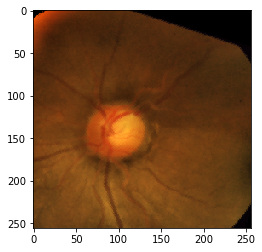

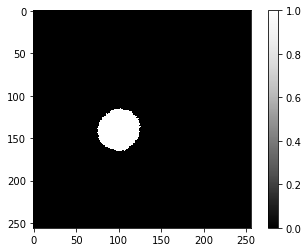

In [198]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.colorbar(); plt.show()

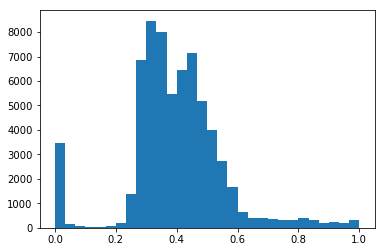

In [199]:
_ = plt.hist(batch[0][0][0].ravel(), bins=30)

In [200]:
arch_name = "OD Cup, U-Net on DRISHTI-GS fold 0 256 px, binary output maps, SGD, high augm with more zoom, CLAHE, log_dice loss"
weights_folder = '../models_weights/' \
                 '{},{}/'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name)

In [201]:
weights_folder

'../models_weights/23.02,14:47,OD Cup, U-Net on DRISHTI-GS fold 0 256 px, binary output maps, SGD, high augm with more zoom, CLAHE, log_dice loss/'

In [202]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


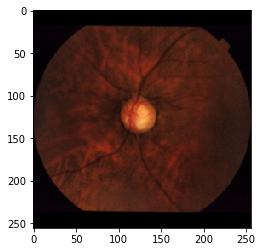

(10, 3, 256, 256) (10, 1, 256, 256)


In [203]:
X_valid, Y_valid = data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True).__next__()
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

In [206]:
history = model.fit_generator(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              samples_per_epoch=len(train_idx),
                              max_q_size=1,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              nb_epoch=500, verbose=1,
                              
                              callbacks=[CSVLogger(folder(weights_folder) + '/' + 'training_log.csv', append=True),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=30),
                                         ModelCheckpoint(folder(weights_folder) + '/' + \
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5',
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/500
 1/40 [..............................] - ETA: 7s - loss: 2.1423 - mean_IOU_gpu: 0.0295 - dice: 0.1174

/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


40/40 [==============================] - 4s - loss: 2.6346 - mean_IOU_gpu: 0.0110 - dice: 0.0806 - val_loss: 3.0276 - val_mean_IOU_gpu: 0.0000e+00 - val_dice: 0.0515

In [145]:
print(model.optimizer.lr.get_value())
print(model.optimizer.momentum.get_value())

0.0003000000142492354
0.949999988079071


In [144]:
model.optimizer.lr.set_value(3e-4)
model.optimizer.momentum.set_value(0.95)

In [ ]:
img_no = 30

batch_X = tf_to_th_encoding(X[img_no:img_no + 1].copy())
batch_y = tf_to_th_encoding(Y[img_no:img_no + 1].copy())
#batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
pred = model.predict(batch_X)[0, 0] > 0.5
corr = Y[img_no][..., 0]
print 'predicted:'
plt.imshow(pred, cmap=plt.cm.Greys_r)
plt.show()
print 'correct:'
plt.imshow(corr, cmap=plt.cm.Greys_r)
plt.show()
print 'original image:'
plt.imshow(X[img_no], cmap=plt.cm.Greys_r)
plt.show()

In [ ]:
mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()

In [ ]:
plt.hist(pred.ravel())

### Comprehensive visual check

In [ ]:
# Function for rescaling cropped cup region and putting it back into original image,
# and resizing the result to 256 x 256.

'''    # not needed for working with images of original size
def rescale_back(cropped, rectangle, orig_size=(512, 512), resulting_size=(256, 256)):
    # cropped must be a grayscale image 
    # rectangle must be an iterable (min_i, min_j, max_i, max_j)
    
    min_i, min_j, max_i, max_j = rectangle
    part_rescaled = sp.misc.imresize(cropped, (max_i - min_i + 1, max_j - min_j + 1))
    resulting_img = np.zeros(orig_size, dtype=cropped.dtype)
    resulting_img[min_i:max_i + 1, min_j:max_j + 1] = part_rescaled
    resulting_img = sp.misc.imresize(resulting_img, resulting_size)
    return resulting_img
'''

In [180]:
optic_disc = h5f['DRISHTI-GS/256 px/disc']

image #0


/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


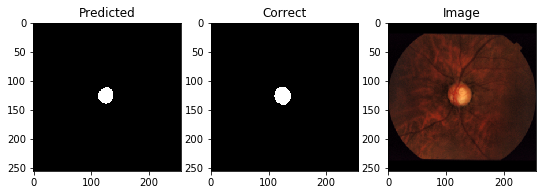

IOU: 0.7757660150527954
Dice: 0.8737254738807678
image #1


/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


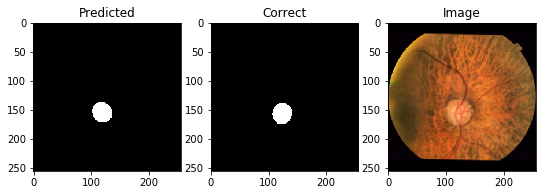

IOU: 0.7212543487548828
Dice: 0.8380566835403442
image #2


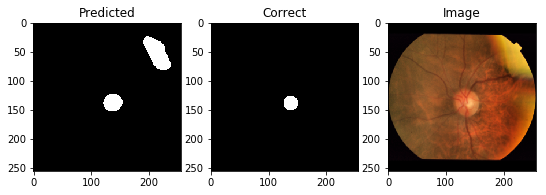

IOU: 0.20235198736190796
Dice: 0.3365935981273651
image #3


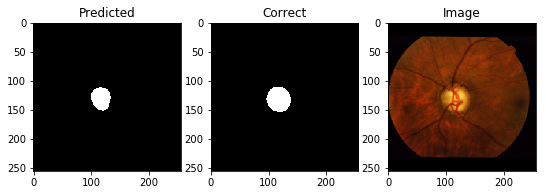

IOU: 0.7369505763053894
Dice: 0.8485567569732666
image #4


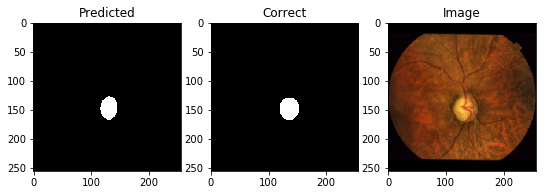

IOU: 0.7108225226402283
Dice: 0.8309716582298279
image #5


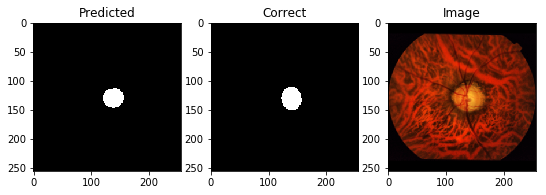

IOU: 0.8330419659614563
Dice: 0.9089174866676331
image #6


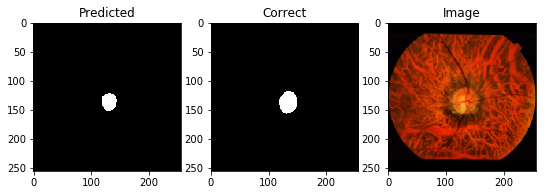

IOU: 0.680672287940979
Dice: 0.8100000023841858
image #7


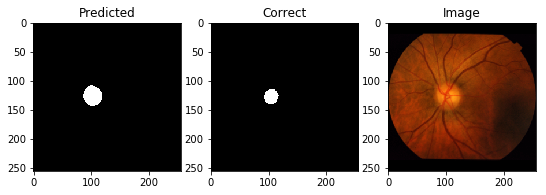

IOU: 0.563554584980011
Dice: 0.7208632826805115
image #8


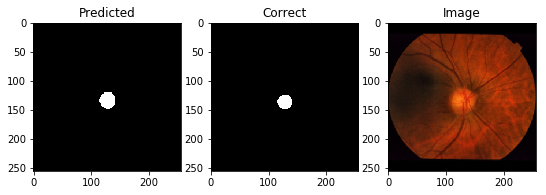

IOU: 0.7318952083587646
Dice: 0.8451957106590271
image #9


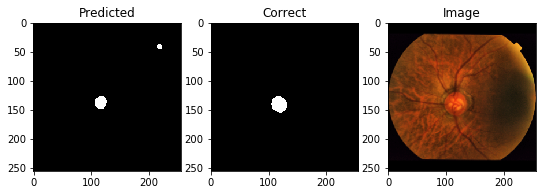

IOU: 0.5337331295013428
Dice: 0.6959921717643738


In [194]:
pred_iou, pred_dice = [], []

for img_no in test_idx:
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = tf_to_th_encoding(X[img_no:img_no + 1].copy())
    batch_y = tf_to_th_encoding(Y[img_no:img_no + 1].copy())
    #batch_X = batch_X / 255.0
    #batch_y = batch_y / 255.0
    #batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0] > 0.5
    
    # intersecting prediction with an optic disc map
    #pred = np.where(optic_disc[img_no, ..., 0], pred, 0.0)
    
    # for cropped version - comparing with original image
    #pred = rescale_back(pred, disc_locations[img_no])
    #corr = Y_orig[img_no, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()
    cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval()
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

In [195]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.649004262686
0.770887


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,  3.,  2.]),
 array([ 0.        ,  0.08243938,  0.16487876,  0.24731814,  0.32975752,
         0.4121969 ,  0.49463629,  0.57707567,  0.65951505,  0.74195443,
         0.82439381]),
 <a list of 10 Patch objects>)

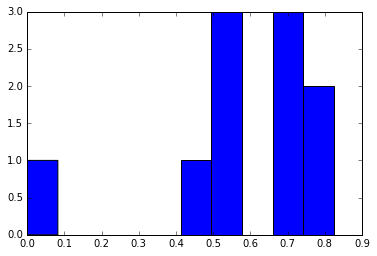

In [70]:
plt.hist(loss)

### Loading model

In [177]:
load_model = False   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    
    # or get the most recent file in a folder:
    model_folder = '../models_weights/23.02,12:39,OD Cup, U-Net on DRISHTI-GS fold 0 256 px, SGD, high augm with more zoom, CLAHE, log_dice loss/'
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)

Loading weights from ../models_weights/23.02,12:39,OD Cup, U-Net on DRISHTI-GS fold 0 256 px, SGD, high augm with more zoom, CLAHE, log_dice loss/last_checkpoint.hdf5


### Save model

In [ ]:
model.save('../models_weights/weights-ep-13_val_mean_IOU-0.061_val_loss_1.82.hdf5')

In [ ]:
model.save_weights('../models_weights/weights-ep-13_val_mean_IOU-0.061_val_loss_1.82_weights_only.hdf5')